# Pronóstico del índice IGAE para México
Se debe diseñar un modelo ARIMA-SARIMA para pronosticar el índice “Índice General de Actividad Económica”. El INEGI publica mensualmente un índice de la actividad económica general para cada industria y para toda la economía. Puedes descargar este índice buscándolo en Google (“inegi bie igae”)


In [107]:
#----LIBRERIAS----
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from scipy.stats import pearsonr
import scipy.stats as stats
from scipy.stats import mstats

Cargamos los datos

In [108]:
#----CARGAR DATOS VALORES----
data = pd.read_csv('IGAE.csv')
df = pd.DataFrame(data)
df.set_index('Descriptores', inplace=True)
df=df.T
df

Descriptores,Índice de volumen físico base 2018=100|Total,Índice de volumen físico base 2018=100|Actividades primarias,Índice de volumen físico base 2018=100|Actividades primarias|111---Agricultura,Índice de volumen físico base 2018=100|Actividades primarias|112---Cría y explotación de animales,Índice de volumen físico base 2018=100|Actividades secundarias,Índice de volumen físico base 2018=100|Actividades secundarias|21---Minería,"Índice de volumen físico base 2018=100|Actividades secundarias|22---Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final",Índice de volumen físico base 2018=100|Actividades secundarias|23---Construcción,Índice de volumen físico base 2018=100|Actividades secundarias|31-33---Industrias manufactureras,Índice de volumen físico base 2018=100|Actividades terciarias,...,Variación porcentual anual de los índices acumulados|Actividades terciarias|52---Servicios financieros y de seguros,Variación porcentual anual de los índices acumulados|Actividades terciarias|53---Servicios inmobiliarios y de alquiler de bienes muebles e intangibles,"Variación porcentual anual de los índices acumulados|Actividades terciarias|54---Servicios profesionales, científicos y técnicos","Variación porcentual anual de los índices acumulados|Actividades terciarias|56---Servicios de apoyo a los negocios y manejo de residuos, y servicios de remediación",Variación porcentual anual de los índices acumulados|Actividades terciarias|61---Servicios educativos,Variación porcentual anual de los índices acumulados|Actividades terciarias|62---Servicios de salud y de asistencia social,"Variación porcentual anual de los índices acumulados|Actividades terciarias|71---Servicios de esparcimiento culturales y deportivos, y otros servicios recreativos",Variación porcentual anual de los índices acumulados|Actividades terciarias|72---Servicios de alojamiento temporal y de preparación de alimentos y bebidas,Variación porcentual anual de los índices acumulados|Actividades terciarias|81---Otros servicios excepto actividades gubernamentales,"Variación porcentual anual de los índices acumulados|Actividades terciarias|93---Actividades legislativas, gubernamentales, de impartición de justicia y de organismos internacionales y extraterritoriales"
1993|Enero,55.434736,58.796198,54.888804,67.248422,63.307782,105.633716,31.140234,65.066709,57.569208,50.775258,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993|Febrero,56.456971,60.763816,56.855371,68.977815,64.889130,97.271624,30.534604,72.301502,59.595205,51.427224,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993|Marzo,58.900549,55.964953,50.409267,67.346044,68.070475,109.363364,30.875150,72.200179,62.293730,53.855214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993|Abril,57.135844,58.989164,52.261002,73.409111,64.524614,105.546017,31.478529,65.190467,59.448857,52.835475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993|Mayo,57.891853,61.762078,55.582213,75.161246,64.382808,108.371887,32.421097,65.265742,58.564004,53.989113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024|Septiembre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024|Octubre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024|Noviembre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024|Diciembre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Nombre de las columnas del Dataset IGAE


In [109]:
df.columns

Index(['Índice de volumen físico base 2018=100|Total',
       'Índice de volumen físico base 2018=100|Actividades primarias',
       'Índice de volumen físico base 2018=100|Actividades primarias|111---Agricultura',
       'Índice de volumen físico base 2018=100|Actividades primarias|112---Cría y explotación de animales',
       'Índice de volumen físico base 2018=100|Actividades secundarias',
       'Índice de volumen físico base 2018=100|Actividades secundarias|21---Minería',
       'Índice de volumen físico base 2018=100|Actividades secundarias|22---Generación, transmisión, distribución y comercialización de energía eléctrica, suministro de agua y de gas natural por ductos al consumidor final',
       'Índice de volumen físico base 2018=100|Actividades secundarias|23---Construcción',
       'Índice de volumen físico base 2018=100|Actividades secundarias|31-33---Industrias manufactureras',
       'Índice de volumen físico base 2018=100|Actividades terciarias',
       ...
       'Varia

Información de la dataset IGAE

In [110]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416 entries, 1993|Enero to 2024|Anual
Columns: 120 entries, Índice de volumen físico base 2018=100|Total to Variación porcentual anual de los índices acumulados|Actividades terciarias|93---Actividades legislativas, gubernamentales, de impartición de justicia y de organismos internacionales y extraterritoriales
dtypes: float64(120)
memory usage: 393.2+ KB


Utilizaremos la columna Índice de volumen físico base 2018=100|Total, es la que contiene el IGAE  de México desde 1993 a 2024

In [111]:
IGAE=df[[ 'Índice de volumen físico base 2018=100|Total']]
IGAE=IGAE.dropna()

Cambiamos el nombre de la columna por IGAE 

In [112]:
IGAE.columns=['IGAE']
IGAE

,IGAE
1993|Enero,55.434736
1993|Febrero,56.456971
1993|Marzo,58.900549
1993|Abril,57.135844
1993|Mayo,57.891853
...,...
2024|Marzo<P>,102.696013
2024|Abril<P>,105.761270
2024|Mayo<P>,107.868081
2024|Junio<R>,104.049350


Vamos a eliminar los renglones que tienen el formato año|Annual, ya que contiene el resumen del año, y ocupamos la información mensual para que mentenga la estructura de serie de tiempo. 

In [113]:
IGAE= IGAE[~IGAE.index.str.contains('Anual')]
IGAE

,IGAE
1993|Enero,55.434736
1993|Febrero,56.456971
1993|Marzo,58.900549
1993|Abril,57.135844
1993|Mayo,57.891853
...,...
2024|Marzo<P>,102.696013
2024|Abril<P>,105.761270
2024|Mayo<P>,107.868081
2024|Junio<R>,104.049350


<hr>

# Modelo ARIMA/SARIMA

Un modelo ARIMA estacional, también llamado modelo ARIMA/SARIMA, generalmente se aplica a series temporales mensuales o trimestrales.
* Datos históricos de ventas mensuales o trimestrales
* Datos históricos de precios mensuales o trimestrales
* Datos históricos mensuales o trimestrales relacionados con cualquier variable de cualquier estado financiero. Por ejemplo: gastos de ventas y administrativos generales, impuesto sobre la renta, EBIT, etc.
* Datos históricos mensuales o trimestrales relacionados con cualquier variable macroeconómica. Por ejemplo: índices de inflación, índices del PIB, tipos de cambio, etc.

Pasos de calibración  ARIMA/ SARIMA 

1. Checar si IGAE es estacionaria con Dicker Fuller
    * IGAE
    * log(IGAE)
    * log(IGAE) - log(IGAE).shift(12)
2. Gráficar ACF y PACF
    * Identificar los parámetros p,d,q,d,q de ARIMA-SARIMA. 
    * ACF → Gráfica de autocorrelación 
    * PACF → Gráfica de autocorrelación parcial 
    * Muestra autocorrelaciones entre la varaible y sus propios retrasos
3. ARIMA(p,d,q)-SARIMA(P,D,Q,#Periods)
    * ARIMA(p,d,q)
    * p → se refiere al número de términos autorregresivos (AR). Generalmente es 0,1, o 2.
    * d → Se refiere a cuántas primeras diferencias fueron necesaria para la serie con el fin de hacer que la serie sea estacionaria. Generalmente es 0 o 1.
    * q → Se refiere al número de términos de media móvil (MA) en el modelo. Generalmente es 0, 1 o 2. 
    * -----------------------------------------------------------------------------------------
    * SARIMA(P,D,Q,#Periods)
    * P → Se refiere al número de términos autorregresivos 'ESTACIONALES'. General es 0 o 1.
    * D → Se refiere a cuántas diferencias ESTACIONALES se necesitaron a la serie sea que la serie fuera estionaria. Normalmente es 0 o 1. 
    * Q → Se refiere al número de términos de media móvil 'ESTACIONAL'. Normalmente es 0 o 1. 
    * #periodos → Hace referencia al número del periodo del año. Si los datos son mensuales #periodo=12.
4. Estimar/Ejecutar el primer modelo ARIMA-SARIMA
5. Ejecutar ACF y PACF de los residuos/errores del modelo para verificar si los errores son una serie del ruido blanco. En otra palabras, si no existen autocorrelaciónes significativas de los errores. 
    * Si hay uno o más autocorrelaciones significativas, podemos incluir otros términos en el modelo ARIMA-SARIMA y volver a 4)
    * Si los errores parecen un ruido blanco (sin autocorrelaciones significativas), entonces podemos continuar y finalizar el proceso de calibración.
6. Interpretar el modelo 
7.  Ejecutar un pronóstivo usando el modelo


## Paso 1 
* IGAE   
* log(IGAE)
* log(IGAE) - log(IGAE).shift(12)

In [114]:
import numpy as np
from statsmodels.tsa.stattools import adfuller

# Calcular logaritmo de la serie
IGAE['log_y'] = np.log(IGAE['IGAE'])

# Calcular la diferencia anual (log(y) - log(y).shift(12))
IGAE['log_y_diff_annual'] = IGAE['log_y'] - IGAE['log_y'].shift(12)

# Eliminar los NaN generados por el shift
IGAE.dropna(inplace=True)

IGAE[['IGAE', 'log_y', 'log_y_diff_annual']].head()


C:\Users\KOKAS\AppData\Local\Temp\ipykernel_9568\1111788160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IGAE['log_y'] = np.log(IGAE['IGAE'])
C:\Users\KOKAS\AppData\Local\Temp\ipykernel_9568\1111788160.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IGAE['log_y_diff_annual'] = IGAE['log_y'] - IGAE['log_y'].shift(12)
C:\Users\KOKAS\AppData\Local\Temp\ipykernel_9568\1111788160.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the d

,IGAE,log_y,log_y_diff_annual
1994|Enero,57.732603,4.055822,0.040616
1994|Febrero,57.413074,4.050272,0.016793
1994|Marzo,59.741928,4.090034,0.014184
1994|Abril,60.613631,4.104520,0.059088
1994|Mayo,60.687763,4.105742,0.047165


## Dicker Fuller 
* log(y)
* log(y) - log(y).shift(12)


Busca verificar la presencia de una raíz unitaria en una serie de tiempo, lo que indica si es estacionaria o no. 

Hipótesis nula (H0): La serie de tiempo tiene una raíz unitaria, es decir, no es estacionaria (contiene una tendencia estocástica).

Hipótesis alternativa (H1): La serie de tiempo es estacionaria (no tiene una raíz unitaria).



In [115]:
def Dicker_Fuller(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    return result[1] < 0.05  # Si el p-value es menor a 0.05, es estacionaria

# Prueba para log(y)
print("Prueba para log(y):")
Dicker_Fuller(IGAE['log_y'])

# Prueba para la diferencia anual
print("\nPrueba para log(y) - log(y).shift(12):")
Dicker_Fuller(IGAE['log_y_diff_annual'])


Prueba para log(y):
ADF Statistic: -1.064490
p-value: 0.729023

Prueba para log(y) - log(y).shift(12):
ADF Statistic: -3.901362
p-value: 0.002025


True

## Paso 2
Graficar ACF y PACF con la variable estacionaria
*  Log(y) - Log(y).shift(12)

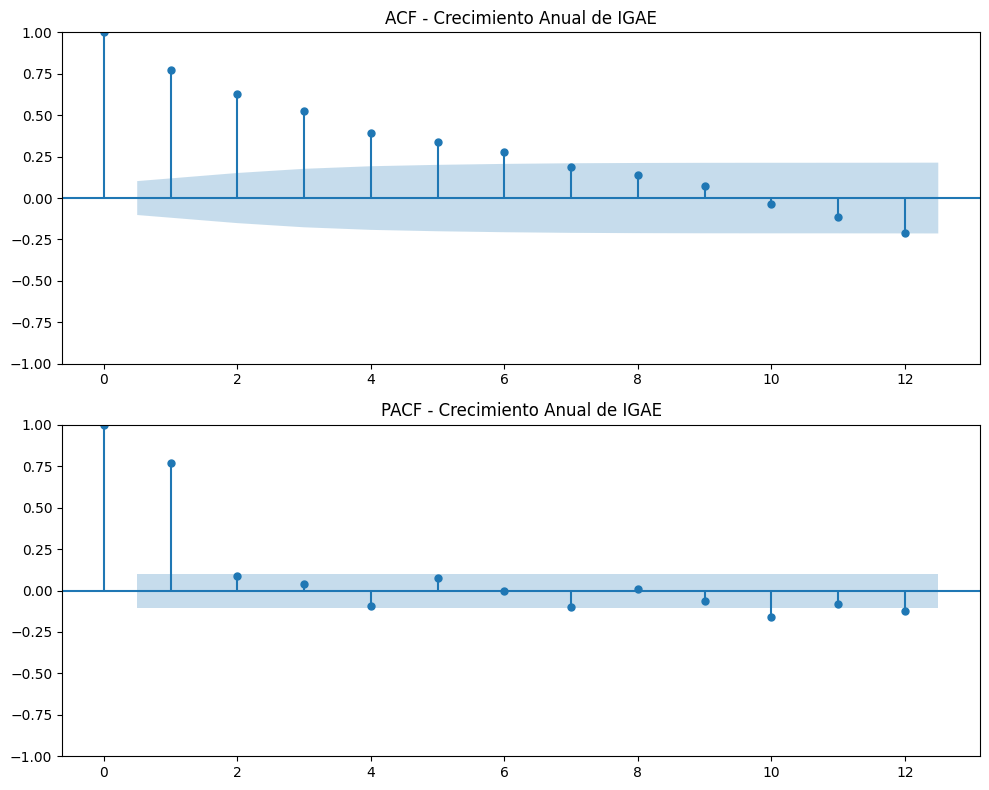

In [116]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Graficar ACF y PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# ACF para Log(y) - Log(y).shift(12)
plot_acf(IGAE['log_y_diff_annual'], ax=ax[0], lags=12)
ax[0].set_title('ACF - Crecimiento Anual de IGAE')

# PACF para Log(y) - Log(y).shift(12)
plot_pacf(IGAE['log_y_diff_annual'], ax=ax[1], lags=12)
ax[1].set_title('PACF - Crecimiento Anual de IGAE')

plt.tight_layout()
plt.show()


## Estamos modelando el % DE CRECIMIENTO ANUAL del IGAE mes a mes.

### ACF - Función Autocorrelación
MA(q) → Promedio móvil, captura las dependencias entre un valor y los errores de predicción de retraso anterior.
Observamos que los primeros 6 retrasos son significativos y decaen gradualmente.

    Gráfico ACF muestra autocorrelaciones independientemente unas de otras.

1. El AC del LAG 1 es aproximadamente del 75%, que significa exite una correlación del crecimiento anual IGAE con su propio crecimiento anual del mes anterior.
2. El AC del LAG 2 es aproximadamente del 60%, que significa exite una correlación del crecimiento anual IGAE con su propio crecimiento anual del mes anterior.
3. El AC del LAG 3 es aproximadamente del 50%, que significa exite una correlación del crecimiento anual IGAE con su propio crecimiento anual del mes anterior.
4. El AC del LAG 4 es aproximadamente del 40%, que significa exite una correlación del crecimiento anual IGAE con su propio crecimiento anual del mes anterior.
5. El AC del LAG 5 es aproximadamente del 30%, que significa exite una correlación del crecimiento anual IGAE con su propio crecimiento anual del mes anterior.
6. El AC del LAG 6 es aproximadamente del 20%, que significa exite una correlación del crecimiento anual IGAE con su propio crecimiento anual del mes anterior.
7. El AC del LAG 12 es aproximadamente del -10%, que significa exite una correlación del crecimiento anual IGAE con su propio crecimiento anual del mes anterior.

El lag 12 sugiere  que la serie tiene un patrón estacional con periodicidad de 12 periodos, y como nuestros datos son mensuales, hay la posibilidad de que exista periodicidad estacionalidad anual. 



### PACF - Función Autocorrelación Parcial 
AR(p) → Autogresivos, cuenta valores del pasado que influyen en valores actuales, y son todos aquellos lags que están fuera de la banda de confianza, sugiere dependiencia directa entre los valores pasados y el valor actual.
Miden CUÁNTO MÁS está correlacionada la serie con cada uno de sus propios RETRASOS, DESPUÉS DE CONSIDERAR el efecto de las AUTOCORRELACIONES DE RETRASO DE ORDEN INFERIOR.

Veo que el PACF muestra que solo las 2 primeras autocorrelaciones son positivas y significativas, y la magnitud de las siguientes autocorrelaciones desciende a cero o negativas muy rápidamente.

1. El PAC del LAG 1 es aproximadamente del 75% de correlación con el mes anterior.
2. El PAC del LAG 4 es aproximadamente del -9% de correlacion de los dos meses anteriores. 
3. El PAC del LAG 7 es aproximadamente del -10% de correlacion de los 10 meses anteriores.
4. El PAC del LAG 10 es aproximadamente del -15% de correlacion de los 12 meses anteriores. 
4. El PAC del LAG 12 es aproximadamente del -12% de correlacion de los 12 meses anteriores. 

        Cuando el gráfico ACF muestra una DECLINACIÓN LENTA de autocorrelaciones y el PACF muestra una DECLINACIÓN RÁPIDA de autocorrelaciones, esto es un PATRÓN DE UN MODELO AR(p) claro. En este caso, el número de términos AR está determinado por los RETRASOS SIGNIFICATIVOS en el gráfico PACF. 


### ARIMA
ARIMA es útil para series temporales no estacionarias que no presentan estacionalidad. 

In [117]:
from statsmodels.tsa.arima.model import ARIMA
# Ajustar el modelo ARIMA (1, 0, 0)
p, d, q = 4, 0, 0
arima_model = ARIMA(IGAE['log_y'], order=(p, d, q),)
arima_result = arima_model.fit()

# Resumen del modelo ARIMA
print(arima_result.summary())



C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  log_y   No. Observations:                  367
Model:                 ARIMA(4, 0, 0)   Log Likelihood                 756.503
Date:                Fri, 18 Oct 2024   AIC                          -1501.006
Time:                        21:03:02   BIC                          -1477.574
Sample:                             0   HQIC                         -1491.696
                                - 367                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3785      0.185     23.663      0.000       4.016       4.741
ar.L1          0.6918      0.043     15.958      0.000       0.607       0.777
ar.L2          0.0634      0.051      1.241      0.2

### Coeficientes 
1. const = 4.3785:
    Es el valor promedio esperado en ausencia de los efectos de los términos autoregresivos
    Esto nos indica que si no hubiera ruido, el valor promedio de la serie sería 4.37, la serie se centra alrededor del 4.37.

2. ar.L1 = 0.6918 :
    Es el primer termino autoregresivo de orden 1. Representa la influencia del valor inmediatamente del mes anterior sobre el valor actual. 
    Este es un valor positivo, por lo que hay una relación positiva, entonces podemos decir que 69% de la variación actual en la serie puede ser explicarse por el valor de la serie en el periodo anterior. 

3. ar.L2 = 0.0634:
    Este es el segundo termino autoregresivo de orden 2. Un valor positivo que indica un relación positiva dos periodos atrás, por lo que, podemos decir que 6.34% de las variaciones actuales en la serie es posible explicarse por el valor de la serie en el periodo 2 valores anteriores.

4. ar.L3 = 0.1389 :
    Este es el tercero termino autoregresivo de orden 3. Un valor positivo que indica un relación positiva tres periodos atrás, por lo que, podemos decir que 13.89% de las variaciones actuales en la serie es posible explicarse por el valor de la serie en el periodo 3 valores anteriores.

5. ar.L4 = 0.1011 :
    Este es el cuarto termino autoregresivo de orden 4. Un valor positivo que indica un relación positiva dos periodos atrás, por lo que, podemos decir que 10.11% de las variaciones actuales en la serie es posible explicarse por el valor de la serie en el periodo 4 valores anteriores.

6. sigma2 = 0.0009:
    Varianza del error o ruido del modelo, indica que los errores del modelo son pequeños, lo que sugiere que el modelo se ajusta bien a los datos. La mayoria de las flutaciones se puede explicar con Lag1, Lag2, Lag3 y Lag4.  


$$
y_t = 4.3785 + 0.6918 \cdot y_{t-1} + 0.0634 \cdot y_{t-2} +   0.1389\cdot y_{t-3}+ 0.1011 \cdot y_{t-4} + \varepsilon_t
$$



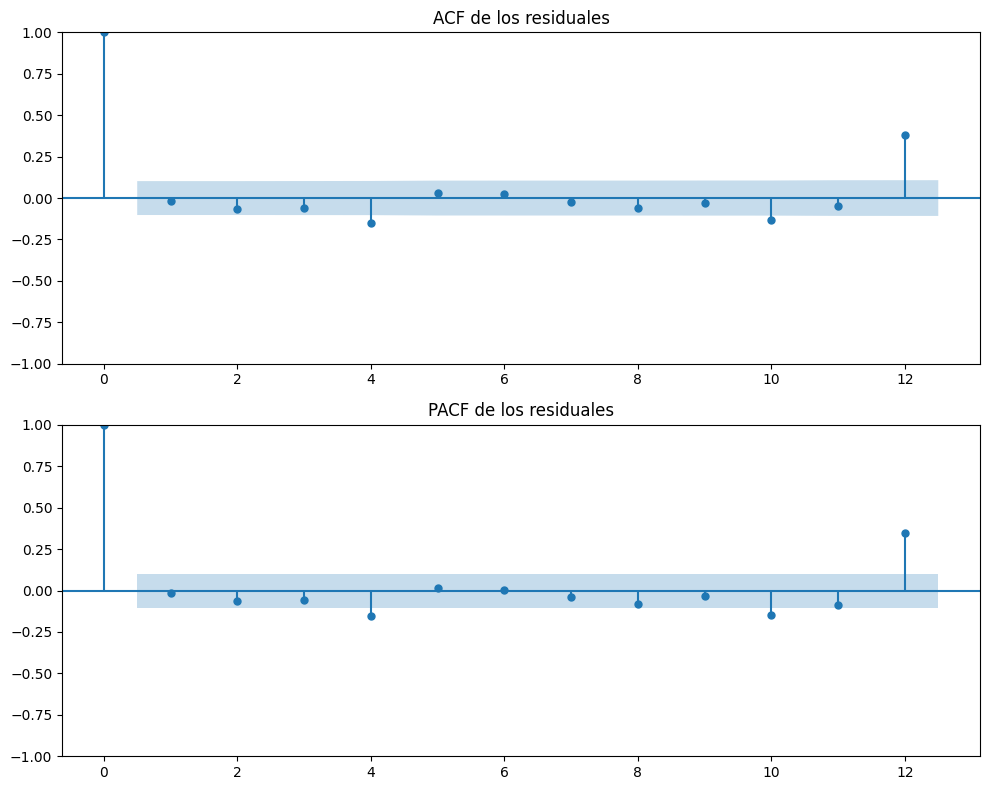

In [118]:
# Gráfica de residuales del modelo ARIMA
residuals = arima_result.resid

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, ax=ax[0], lags=12)
ax[0].set_title('ACF de los residuales')

plot_pacf(residuals, ax=ax[1], lags=12)
ax[1].set_title('PACF de los residuales')

plt.tight_layout()
plt.show()

#### Ruido Blanco 
Al estar trabajando con un modelo que funciona con series no estacionarias, es importante se subir la complejidad para disminuir varaible que impacten a nuestro modelo para que sea solo el ruido blanco. Hay lags que son significativas que son estacionarias, por lo que tenemos que aplicar un modelo sarima. 

### SARIMA
Es especialmente útil cuando la serie temporal tiene patrones repetitivos a intervalos regulares (estacionalidad)

In [119]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Ajustar el modelo SARIMA 
p, d, q = 4, 0, 0 # ARIMA
P, D, Q, s = 4, 0, 2, 12 # Estacionales

sarima_model = SARIMAX(IGAE['log_y_diff_annual'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit()

# Resumen del modelo SARIMA
print(sarima_result.summary())


C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                       log_y_diff_annual   No. Observations:                  367
Model:             SARIMAX(4, 0, 0)x(4, 0, [1, 2], 12)   Log Likelihood                 859.535
Date:                                 Fri, 18 Oct 2024   AIC                          -1697.069
Time:                                         21:03:13   BIC                          -1654.110
Sample:                                              0   HQIC                         -1680.000
                                                 - 367                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8662      0.037     23.273      0.000       0.793       0

### Coeficientes 

1. ar.L1 = 0.8662:

    * Este es el coeficiente del primer término autoregresivo (AR) de orden 1. 
    * Con un valor de 0.8662, sugiere una fuerte relación positiva con el valor del periodo anterior. Aproximadamente el 86.62% de la variación actual en la serie puede explicarse por el valor de la serie en el periodo inmediatamente anterior.

2. ar.L2 = 0.0238:

    * Este es el coeficiente del segundo término autoregresivo de orden 2. 
    * El valor de 0.0238 indica una relación positiva muy débil, lo que significa que solo el 2.38% de las variaciones actuales en la serie pueden ser explicadas por el valor de la serie dos periodos atrás.


3. ar.L3 = -0.0118:

    * Este es el coeficiente del tercer término autoregresivo de orden 3.
    * Con un valor de -0.0118, muestra una relación negativa muy débil, lo que sugiere que la influencia de tres periodos atrás en la serie es mínima y de signo opuesto, con solo un 1.18% de impacto en sentido inverso.


4. ar.L4 = 0.0713:

    * Este es el coeficiente del cuarto término autoregresivo de orden 4. Refleja la relación entre el valor actual de la serie y el valor de cuatro.
    * El valor positivo de 0.0713 sugiere una influencia positiva moderada; alrededor del 7.13% de la variación actual en la serie puede explicarse por el valor de la serie en el periodo de hace cuatro unidades de tiempo.


5. ar.S.L12 = -0.4450:

    * Este es el coeficiente del término autoregresivo estacional (AR) con un rezago de 12 periodos (una temporada completa, si los datos son mensuales).
    * El valor negativo de -0.4450 indica una relación inversa significativa con el valor de la serie 12 periodos atrás. Aproximadamente el 44.50% de la variación actual puede atribuirse al valor de la serie en el mismo periodo de la temporada pasada, pero en una dirección opuesta.


6. ar.S.L24 = -0.6844:

    * Este es el coeficiente del segundo término autoregresivo estacional (AR) con un rezago de 24 periodos.
    * Un valor negativo de -0.6844 implica una relación inversa aún más fuerte con el valor de hace dos temporadas completas. Aproximadamente el 68.44% de la variación actual está relacionada negativamente con el valor de hace 24 periodos.


7. ar.S.L36 = -0.4294:

    * Este es el coeficiente del tercer término autoregresivo estacional con un rezago de 36 periodos.
    * El valor de -0.4294 indica una influencia negativa del 42.94% de la serie tres temporadas atrás, lo que refuerza la presencia de ciclos o patrones estacionales recurrentes, aunque con una influencia decreciente.


8. ar.S.L48 = -0.5912:

    * Este es el coeficiente del cuarto término autoregresivo estacional con un rezago de 48 periodos.
    * Con un valor negativo de -0.5912, muestra que existe una relación negativa significativa (59.12%) entre el valor actual y el valor cuatro temporadas atrás. Esto podría indicar una fuerte reversión en los patrones estacionales en estos periodos.


9. ma.S.L12 = -0.2270:

    * Este es el coeficiente del primer término de promedio móvil estacional (MA) con un rezago de 12 periodos.
    * Un valor de -0.2270 sugiere que el error de la predicción hecha hace 12 periodos tiene una influencia inversa del 22.70% en el valor actual, lo que ajusta la predicción considerando errores pasados.


10. ma.S.L24 = 0.1698:

    * Este es el coeficiente del segundo término de promedio móvil estacional con un rezago de 24 periodos.
    * Un valor positivo de 0.1698 indica que el error de predicción hecho hace dos temporadas tiene una influencia positiva del 16.98% en la predicción actual, ajustando el valor en base a errores pasados.

11. sigma2 = 0.0005:

* Este es el valor de la varianza residual (sigma al cuadrado), que representa la varianza del error o el ruido del modelo.
* Con un valor tan pequeño (0.0005), indica que los errores del modelo son mínimos, lo que sugiere que el modelo tiene un ajuste sólido a los datos observados. La mayor parte de las fluctuaciones en la serie pueden explicarse adecuadamente por los términos autoregresivos y de promedio móvil.

$$

y_t=0.8662+y_{(t−1)}+0.0238*y_{(t−2)}−0.0118*y_{(t−3)}+0.0713*y_{(t−4)}−0.4450*y_{(t−12)}
−0.6844*y_{(t−24)}−0.4294*y_{(t−36)}−0.5912*y_{(t−48)}−0.2270*ε{(t−12)}+0.1698*ε_{(t−24)}+ε
$$

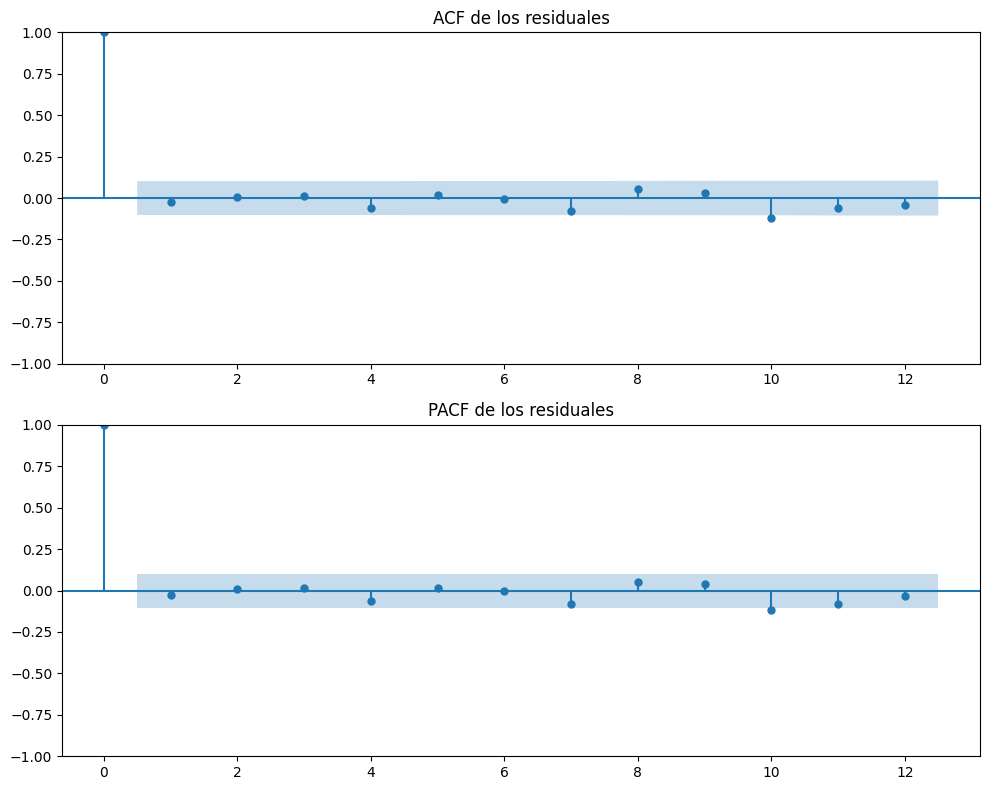

In [120]:
# Gráfica de residuales del modelo SARIMA
residuals = sarima_result.resid

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(residuals, ax=ax[0], lags=12)
ax[0].set_title('ACF de los residuales')

plot_pacf(residuals, ax=ax[1], lags=12)
ax[1].set_title('PACF de los residuales')

plt.tight_layout()
plt.show()

#### Ruido Blanco 
Al utilizar el modelo SARIMA es posible tener mejores resultado para modelar e implementar las variable explicariva para predecir el crecimeinto porcentual del IGAE Anual me a mes, no obtante, al estar moviendo los para metros de efectos parciales y autoregresivos, obtuvimos un ajuste que nos da un p-value mayor 0.05, que significa que no extiste relacion significativo de los lags y los residuos. 


### Ljung-Box
         Prueba de Ljung-Box (o Q-statistic), que se usa para evaluar si los residuos de un modelo temporal son autocorrelacionados. Específicamente, la prueba de Ljung-Box analiza si un conjunto de autocorrelaciones en varias defasajes (lags) es significativamente diferente de cero, lo que ayudaría a determinar si los residuos son "ruido blanco" o si aún hay patrones no explicados por el modelo.

In [121]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Residuos del modelo
residuals = sarima_result.resid

# Prueba de Ljung-Box para diferentes lags (ajusta el número de lags si es necesario)
lb_test = acorr_ljungbox(residuals, lags=[12], return_df=True)
print(lb_test)


      lb_stat  lb_pvalue
12  13.224691   0.352923


Dado a que pvalue es mayor a 0.05, se puede concluir que los residuos no muestran evidencia significativa de autocorrelación. Se puede decir, que los residuos podrían ser ruido blanco.

<hr>

## Predicciones Modelo SARIMA 
 
 Al tener un modelo que simule el comportamiento del cricimiento porcental mesual del IGAE se puede a ser predicciones futuras, para este caso lo haremos para los próximos 72 meses que dura el nuevo sexenio.

In [122]:
IGAE

,IGAE,log_y,log_y_diff_annual
1994|Enero,57.732603,4.055822,0.040616
1994|Febrero,57.413074,4.050272,0.016793
1994|Marzo,59.741928,4.090034,0.014184
1994|Abril,60.613631,4.104520,0.059088
1994|Mayo,60.687763,4.105742,0.047165
...,...,...,...
2024|Marzo<P>,102.696013,4.631773,-0.013507
2024|Abril<P>,105.761270,4.661184,0.051635
2024|Mayo<P>,107.868081,4.680909,0.015713
2024|Junio<R>,104.049350,4.644865,-0.003771


## Modelo SARIMA para Log(IGAE) - No estacionario

In [123]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Ajustar el modelo SARIMA
p, d, q = 4, 0, 0  # ARIMA
P, D, Q, s = 4, 1, 2, 12  # Estacional

sarima_model = SARIMAX(IGAE['log_y'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit()

# Resumen del modelo SARIMA
print(sarima_result.summary())

C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                                   log_y   No. Observations:                  367
Model:             SARIMAX(4, 0, 0)x(4, 1, [1, 2], 12)   Log Likelihood                 826.955
Date:                                 Fri, 18 Oct 2024   AIC                          -1631.910
Time:                                         21:03:29   BIC                          -1589.317
Sample:                                              0   HQIC                         -1614.965
                                                 - 367                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8578      0.037     22.941      0.000       0.785       0

C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


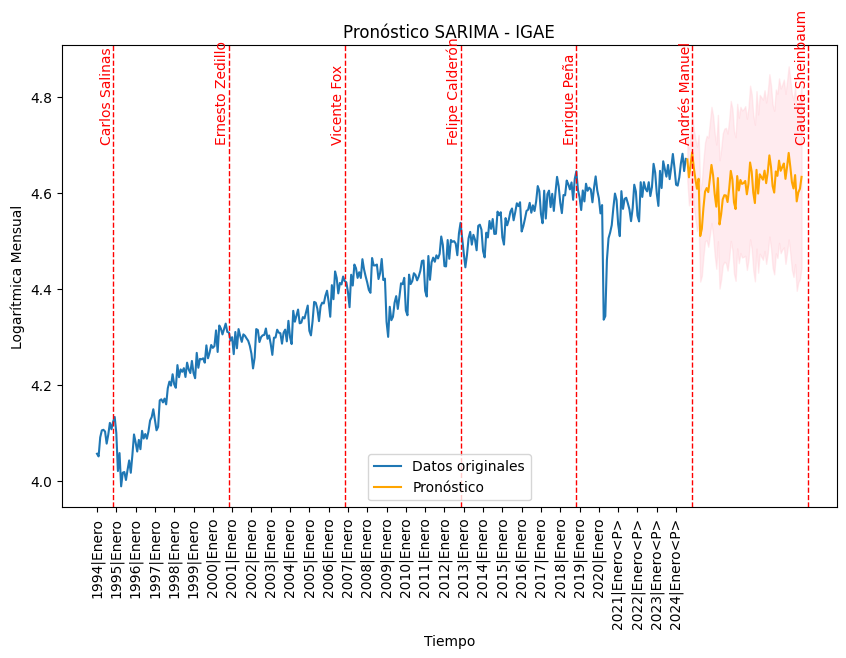

In [124]:


# Número de períodos para pronosticar (ejemplo: 12 períodos)
forecast_steps = 72

# Realizar el pronóstico
forecast = sarima_result.get_forecast(steps=forecast_steps)

# Obtener el intervalo de confianza para el pronóstico
confidence_intervals = forecast.conf_int()

# Extraer los valores predichos del pronóstico
predicted_values = forecast.predicted_mean

# Graficar el pronóstico junto con los intervalos de confianza
plt.figure(figsize=(10, 6))

# Graficar los datos originales
plt.plot(IGAE.index, IGAE['log_y'], label='Datos originales')

# Graficar los valores predichos
plt.plot(predicted_values.index, predicted_values, label='Pronóstico', color='orange')

# Graficar el intervalo de confianza
plt.fill_between(predicted_values.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Pronóstico SARIMA - IGAE')
plt.xlabel('Tiempo')
plt.ylabel('Logarítmica Mensual')
plt.legend()
# Añadir líneas verticales cada 72 meses y etiquetas para los mandatos
presidentes = [
    ("Carlos Salinas", 10),
    ("Ernesto Zedillo", 82),
    ("Vicente Fox", 154),
    ("Felipe Calderón", 226),
    ("Enrique Peña", 298),
    ("Andrés Manuel", 370),
    ("Claudia Sheinbaum", 442)
]

for nombre, x in presidentes:
    plt.axvline(x=x, color='r', linestyle='--', linewidth=1)  # Línea vertical roja
    plt.text(x-4, 4.7, nombre, color='red', ha='center', va='bottom', fontsize=10,rotation=90)

# Configurar las etiquetas del eje x
plt.xticks(rotation=90)  # Rotar las etiquetas para una mejor legibilidad
plt.xticks(np.arange(0, len(IGAE['log_y_diff_annual']), step=12))  # Mostrar ticks cada 12 meses

plt.show()

1. Durante el periodo de Carlos Salinas se percibe un crecimiento económico inicial.

2. En el periodo de Ernesto Zedillo se evidencia un crecimiento sostenido, pero afectado por la crisis de 1995.

3. Durante los mandatos de Vicente Fox y Felipe Calderón hay crecimiento estable, con una caída pronunciada en 2009 debido a la crisis financiera.

4. En el sexenio de Enrique Peña Nieto se recupera el crecimiento tras la caída anterior.

5. El periodo de Andrés Manuel López Obrador está marcado por una fuerte caída debido a la pandemia de COVID-19 en 2020, seguido por una recuperación parcial. El pronóstico para su sexenio muestra alta incertidumbre hacia el futuro.

6.  El pronóstico se extiende hacia el mandato de Claudia Sheinbaum, donde la predicción SARIMA muestra una mayor incertidumbre respecto al crecimiento económico, probablemente influido por factores externos o nuevas crisis económicas.

## Modelo SARIMA para Log(IGAE)-Log(IGAE).shift(12) - Estacionario

In [125]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Ajustar el modelo SARIMA
p, d, q = 4, 0, 0  # ARIMA
P, D, Q, s = 4, 0, 2, 12  # Estacional

sarima_model = SARIMAX(IGAE['log_y_diff_annual'], order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_result = sarima_model.fit()

# Resumen del modelo SARIMA
print(sarima_result.summary())

C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                        
Dep. Variable:                       log_y_diff_annual   No. Observations:                  367
Model:             SARIMAX(4, 0, 0)x(4, 0, [1, 2], 12)   Log Likelihood                 859.535
Date:                                 Fri, 18 Oct 2024   AIC                          -1697.069
Time:                                         21:03:41   BIC                          -1654.110
Sample:                                              0   HQIC                         -1680.000
                                                 - 367                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8662      0.037     23.273      0.000       0.793       0

C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\KOKAS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


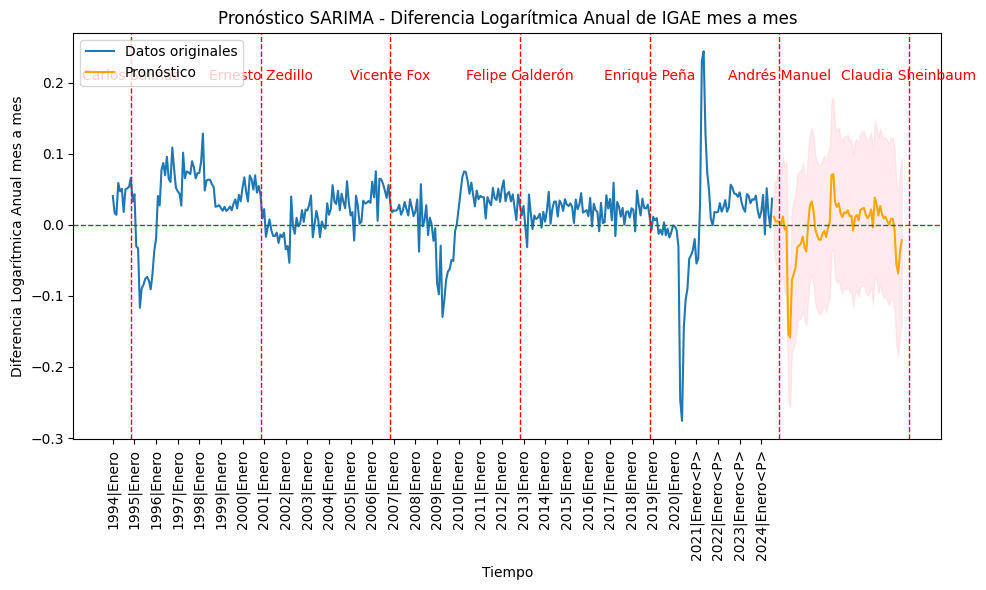

In [127]:


# Número de períodos para pronosticar (ejemplo: 12 períodos)
forecast_steps = 72

# Realizar el pronóstico
forecast = sarima_result.get_forecast(steps=forecast_steps)

# Obtener el intervalo de confianza para el pronóstico
confidence_intervals = forecast.conf_int()

# Extraer los valores predichos del pronóstico
predicted_values = forecast.predicted_mean

# Graficar el pronóstico junto con los intervalos de confianza
plt.figure(figsize=(10, 6))

# Graficar los datos originales
plt.plot(IGAE.index, IGAE['log_y_diff_annual'], label='Datos originales')

# Graficar los valores predichos
plt.plot(predicted_values.index, predicted_values, label='Pronóstico', color='orange')

# Graficar el intervalo de confianza
plt.fill_between(predicted_values.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.title('Pronóstico SARIMA')
plt.legend()
# Añadir líneas verticales cada 72 meses y etiquetas para los mandatos
presidentes = [
    ("Carlos Salinas", 10),
    ("Ernesto Zedillo", 82),
    ("Vicente Fox", 154),
    ("Felipe Calderón", 226),
    ("Enrique Peña", 298),
    ("Andrés Manuel", 370),
    ("Claudia Sheinbaum", 442)
]

for nombre, x in presidentes:
    plt.axvline(x=x, color='r', linestyle='--', linewidth=1)  # Línea vertical roja
    plt.text(x, 0.2, nombre, color='red', ha='center', va='bottom', fontsize=10)

# Configurar las etiquetas del eje x
plt.xticks(rotation=90)  # Rotar las etiquetas para una mejor legibilidad
plt.xticks(np.arange(0, len(IGAE['log_y_diff_annual']), step=12))  # Mostrar ticks cada 12 meses
plt.axhline(y=0, color='green', linestyle='--', linewidth=1)  # Línea horizontal en y=0

# Títulos y etiquetas
plt.title('Pronóstico SARIMA - Diferencia Logarítmica Anual de IGAE mes a mes')
plt.xlabel('Tiempo')
plt.ylabel('Diferencia Logarítmica Anual mes a mes')
plt.legend()  # Agregar leyenda

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el espacio para evitar que las etiquetas se corten
plt.show()



La línea azul representa la tasa de crecimiento (o decrecimiento) anual mes a mes en términos logarítmicos del IGAE. La diferencia logarítmica permite visualizar los cambios porcentuales relativos de una manera suavizada y constante.

Se pueden observar fluctuaciones en la tasa de crecimiento a lo largo del tiempo, con algunos periodos de desaceleración o decrecimiento (valores negativos), así como fases de crecimiento económico (valores positivos).
* Caída notable en 1995 (crisis del peso mexicano) 
* En 2009 (crisis financiera global) s
* Al igual que una caída muy pronunciada en 2020 debido a la pandemia de COVID-19.

Pronóstico (línea naranja): La línea naranja corresponde al pronóstico SARIMA para las diferencias logarítmicas del IGAE a partir de un punto cercano a 2021. Este pronóstico sugiere una desaceleración en el crecimiento (valores cercanos a cero o negativos), con fluctuaciones pero sin un crecimiento acelerado.Es notable cómo la incertidumbre aumenta considerablemente después de 2021, reflejando la dificultad de predecir con precisión el comportamiento económico en el largo plazo.Cada presidencia coincide con diferentes dinámicas económicas, como un crecimiento sostenido durante Vicente Fox y Felipe Calderón, seguido de fluctuaciones durante Enrique Peña Nieto. En el periodo de Andrés Manuel López Obrador, el impacto de la pandemia es evidente, con la fuerte caída en 2020.
El pronóstico hacia el periodo de Claudia Sheinbaum proyecta un crecimiento moderado o incluso una posible contracción económica.

<hr>



# Conclusiones

Es posible que nuestro modelo que predice el IGAE continúe su moderado crecimiento con fluctuaciones menores. Sin embargo, esta es solo una proyección basada en la estabilidad observada. Por otra parte es de suma importancia tener en ceunta factores económicos externos e internos, un ejemplo podría se la economía de México podría influenciada por factores globales como el crecimiento económico de los socios comerciales, cambios en políticas comerciales, crisis financieras globales o avances tecnológicos. No obstante, es importante tener en consideración factores internos como reformas económicas, estabilidad política, reformas fiscales, o cambios en sectores clave de la economía (como energías renovables o la manufactura) podrían impactar el crecimiento del IGAE más allá del 2024. Por último, para predecir con mayor precisión el comportamiento del IGAE después de 2024, sería necesario recalibrar los modelos econométricos a medida que se obtengan nuevos datos y tal vez usar métodos adicionales como modelos de largo plazo que consideren variables estructurales y coyunturales del país.